# Make a full overview of number counts for SPIRE bands



In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
#plt.rc('figure', figsize=(10, 6))
from matplotlib_venn import venn3

import herschelhelp 
from herschelhelp.utils import clean_table

from astropy.table import Table, vstack

import pyvo as vo

from pymoc import MOC

import time

import yaml



import warnings
warnings.filterwarnings('ignore')

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#Then we establish the VO connection to our database
service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap"
                           )

In [3]:
fields = yaml.load(open('../../../dmu2/meta_main.yml', 'r'))['fields']

In [4]:
bands = [
    'pacs_green', 
    'pacs_red', 
    'spire_250', 
    'spire_350', 
    'spire_500'
]
mag_tables = {}


for band in bands:
    mag_tables[band] = {}
    for f in fields:
      
        mag_tables[band].update({f['name']: None})

In [5]:
start = time.time()
for band in bands:
    print(band)
    
    for f in fields:
     
     
        try:
            
            mag_tables[band].update({f['name'] : Table.read('./data/{}_{}.fits'.format(band, f['name']))})
            print("loaded {} from file ({} objects)".format(band, len(mag_tables[band][f['name']])))
            continue
        except FileNotFoundError:
            print("Querying VOX for {} mags on {}".format(band, f['name']))
    
        query = """
        SELECT 
        f_{}
        FROM herschelhelp.main
        WHERE herschelhelp.main.f_{} IS NOT NULL
        AND herschelhelp.main.field='{}'""".format(
            band, band, 
            f['name'].replace('Lockman-SWIRE','Lockman SWIRE' ).replace('HATLAS-NGP','NGP' ))

        job = service.submit_job(query, maxrec=100000000)
        job.run()
        job_url = job.url
        job_result = vo.dal.tap.AsyncTAPJob(job_url)
        start_time = time.time()
        wait = 10.
        while job.phase == 'EXECUTING':
            #print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
            time.sleep(wait) 
            #wait *=2

        print(job.phase)
        result = job_result.fetch_result()
        mag_tables[band].update({ f['name']: result.table})
        if len(mag_tables[band][f['name']]) != 0:
            print("Band {} field {} done in {} seconds with {} objects".format(
                band, 
                f['name'],                                                         
                round(time.time() - start_time), 
                len(mag_tables[band][f['name']])
            ))
    
print("Total time: {} seconds".format(round(time.time() - start)))

pacs_green
Querying VOX for pacs_green mags on AKARI-NEP
COMPLETED
Querying VOX for pacs_green mags on AKARI-SEP
COMPLETED
Querying VOX for pacs_green mags on Bootes
COMPLETED
loaded pacs_green from file (74543 objects)
loaded pacs_green from file (320092 objects)
Querying VOX for pacs_green mags on EGS
COMPLETED
loaded pacs_green from file (269561 objects)
Querying VOX for pacs_green mags on ELAIS-N2
COMPLETED
loaded pacs_green from file (194276 objects)
Querying VOX for pacs_green mags on GAMA-09
COMPLETED
Querying VOX for pacs_green mags on GAMA-12
COMPLETED
Querying VOX for pacs_green mags on GAMA-15
COMPLETED
Querying VOX for pacs_green mags on HDF-N
COMPLETED
Querying VOX for pacs_green mags on Herschel-Stripe-82
COMPLETED
loaded pacs_green from file (242521 objects)
Querying VOX for pacs_green mags on HATLAS-NGP
COMPLETED
Querying VOX for pacs_green mags on SA13
COMPLETED
Querying VOX for pacs_green mags on HATLAS-SGP
COMPLETED
Querying VOX for pacs_green mags on SPIRE-NEP
COMPL

In [6]:
mag_tables['spire_500']['COSMOS']['f_spire_500']

1624.8127
6099.0557
14704.747
6013.029
2655.986
1953.3529
2241.9885
9633.286
3055.982
1798.1592
1711.7574


In [7]:
mag_tables

{'pacs_green': {'AKARI-NEP': <Table masked=True length=0>
  f_pacs_green
      uJy     
    float64   
  ------------, 'AKARI-SEP': <Table masked=True length=0>
  f_pacs_green
      uJy     
    float64   
  ------------, 'Bootes': <Table masked=True length=0>
  f_pacs_green
      uJy     
    float64   
  ------------, 'CDFS-SWIRE': <Table length=74543>
  f_pacs_green
      uJy     
    float64   
  ------------
       20468.7
     19989.527
     51565.816
      89814.93
     47706.137
     13326.065
     40450.402
     20251.305
     17198.557
           ...
     43843.855
       35989.6
      33890.27
     15138.669
      9895.205
     28168.467
      67009.33
     28514.402
      33462.01
     25555.426, 'COSMOS': <Table length=320092>
    f_pacs_green  
        uJy       
      float64     
  ----------------
  619.362981524318
   819.09797154367
  1292.55931824446
  313.550874125212
  346.451706718653
  385.325431125239
  747.907091863453
  1052.03804560006
   407.78741822578
   

In [8]:
#service.maxrec=100000000
print(service.hardlimit)

20000000


Herschel Stripe 82 hits the hard limit on rows so we must get it from two queries

In [9]:
write = True
read = False
for band in bands:
    for f in fields:
        if write and (len(mag_tables[band][f['name']]) != 0):
            clean_table(mag_tables[band][f['name']]).write(
                './data/{}_{}.fits'.format(band, f['name']), overwrite = True
            )
            print('Table cleaned and written to ./data/{}_{}.fits'.format(band, f['name']))
        elif read:
            mag_tables[band].update( 
                {f['name'] : Table.read('./data/{}_{}.fits'.format(band, f['name']))} 
            ) 
    

f_pacs_green is not a masked columns
Table cleaned and written to ./data/pacs_green_CDFS-SWIRE.fits
f_pacs_green is not a masked columns
Table cleaned and written to ./data/pacs_green_COSMOS.fits
f_pacs_green is not a masked columns
Table cleaned and written to ./data/pacs_green_ELAIS-N1.fits
f_pacs_green is not a masked columns
Table cleaned and written to ./data/pacs_green_ELAIS-S1.fits
f_pacs_green is not a masked columns
Table cleaned and written to ./data/pacs_green_Lockman-SWIRE.fits
f_pacs_red is not a masked columns
Table cleaned and written to ./data/pacs_red_CDFS-SWIRE.fits
f_pacs_red is not a masked columns
Table cleaned and written to ./data/pacs_red_COSMOS.fits
f_pacs_red is not a masked columns
Table cleaned and written to ./data/pacs_red_ELAIS-N1.fits
f_pacs_red is not a masked columns
Table cleaned and written to ./data/pacs_red_ELAIS-S1.fits
f_pacs_red is not a masked columns
Table cleaned and written to ./data/pacs_red_Lockman-SWIRE.fits
f_spire_250 is not a masked co

## Plot the histograms

In [10]:
bands_plotting = {
    'pacs_green':['PACS Green','g'], 
    'pacs_red':['PACS red','r'], 
    'spire_250':['SPIRE 250','b'],  
    'spire_350':['SPIRE 350','c'],  
    'spire_500':['SPIRE 500','m'],  

}

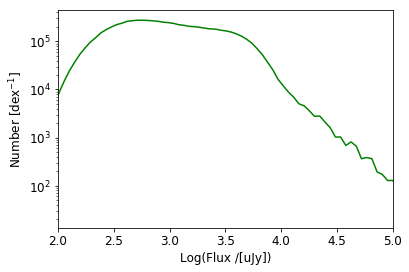

In [25]:
fig, ax = plt.subplots()


f = 'COSMOS'
area = 5
for band in [b for b in mag_tables if b.endswith('green')]:
    mask = np.isfinite(mag_tables[band][f]['f_'+band])
    mags = mag_tables[band][f][mask]['f_'+band]
    if not np.sum(mask)==0:
        #vz.hist(table[name][mask], bins='scott', label=label, alpha=.5)
        h = np.histogram(np.log10(mags), bins = 100)
        bin_width = (np.abs(h[1][5] - h[1][4]) )
        #ax.fill_between( h[1][:-1], h[0]/bin_width)#, alpha=0.4)
        ax.plot( h[1][:-1], h[0]/bin_width , c=bands_plotting[band][1])#, alpha=0.4)


ax.legend(loc=1, fontsize=8)

plt.xlim(2.,5.)
plt.xlabel("Log(Flux /[uJy])")
plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0.,0.4)
plt.ylabel('Number [dex$^{-1}$]')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)


#plt.savefig('./figs/numbers_g_en1.pdf', bbox_inches='tight')
#plt.savefig('./figs/numbers_g_en1.png', bbox_inches='tight')

In [12]:
for n, f in enumerate(fields):
    print(f['name'])

AKARI-NEP
AKARI-SEP
Bootes
CDFS-SWIRE
COSMOS
EGS
ELAIS-N1
ELAIS-N2
ELAIS-S1
GAMA-09
GAMA-12
GAMA-15
HDF-N
Herschel-Stripe-82
Lockman-SWIRE
HATLAS-NGP
SA13
HATLAS-SGP
SPIRE-NEP
SSDF
xFLS
XMM-13hr
XMM-LSS


In [13]:
areas = {}
for band in bands:
    areas.update({band: {}})
    for n, f in enumerate(fields):
        f = f['name']
        f_moc = MOC(filename='../../../dmu2/dmu2_field_coverages/{}_MOC.fits'.format(f))
    
        #band_moc = MOC(10,
        #    depth_result[~np.isnan(depth_result['ferr_{}_mean'.format(band)])]['hp_idx_o_10']
        #)
        area = f_moc.area_sq_deg #.flattened(order=10)
        areas[band].update({f: area})
        
np.save('./data/areas.npy', areas) 

In [14]:

areas = np.load('./data/areas.npy').item()

In [15]:
areas

{'pacs_green': {'AKARI-NEP': 9.194732358779467,
  'AKARI-SEP': 8.713306475131118,
  'Bootes': 11.42815299095486,
  'CDFS-SWIRE': 12.971246403717068,
  'COSMOS': 5.083863478496816,
  'EGS': 3.566383275122158,
  'ELAIS-N1': 13.507484555454763,
  'ELAIS-N2': 9.167479903991113,
  'ELAIS-S1': 9.002940646885508,
  'GAMA-09': 62.01393417284915,
  'GAMA-12': 62.70933280772107,
  'GAMA-15': 61.70114565980842,
  'HDF-N': 0.6717832558166041,
  'Herschel-Stripe-82': 363.22747930641884,
  'Lockman-SWIRE': 22.413863402949218,
  'HATLAS-NGP': 177.6981971077162,
  'SA13': 0.27416379328431184,
  'HATLAS-SGP': 294.5684540900642,
  'SPIRE-NEP': 0.1280660469377391,
  'SSDF': 111.11624949343539,
  'xFLS': 7.44043242140754,
  'XMM-13hr': 0.7570240166583633,
  'XMM-LSS': 21.75457939331374},
 'pacs_red': {'AKARI-NEP': 9.194732358779467,
  'AKARI-SEP': 8.713306475131118,
  'Bootes': 11.42815299095486,
  'CDFS-SWIRE': 12.971246403717068,
  'COSMOS': 5.083863478496816,
  'EGS': 3.566383275122158,
  'ELAIS-N1': 1

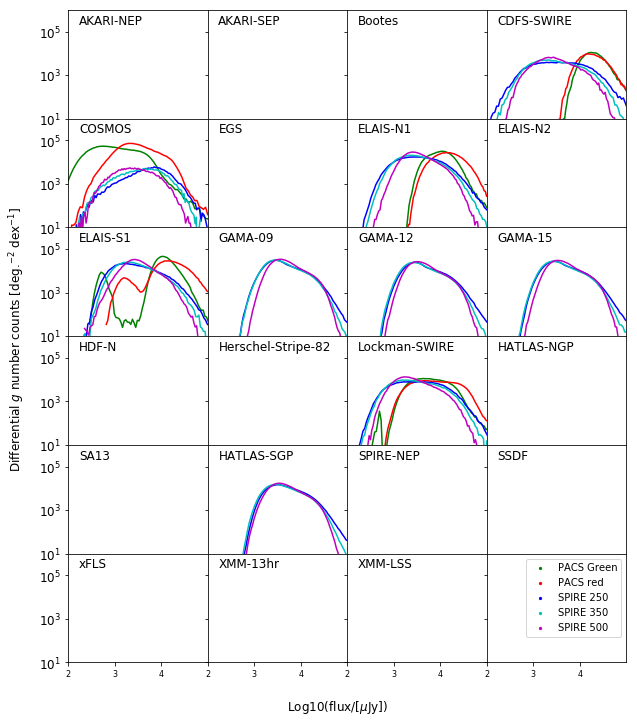

In [32]:
dim = [4,6]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
plt.rcParams.update({'font.size': 12})

#area_per_pixel  = MOC(10, (1234)).area_sq_degrees
for n, f in enumerate(fields):
    f = f['name']
        
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
   
    
    
    for band in mag_tables: #[b for b in mag_tables if b.endswith('g')]:
        mask = np.isfinite(mag_tables[band][f]['f_'+band])
        #mask &= (bands[band][0]['field'] == f)

        
        area = areas[band][f]
        #area=f_moc.area_sq_deg
        mags = mag_tables[band][f][mask]['f_'+band]
        if not np.sum(mask)==0:
            #vz.hist(table[name][mask], bins='scott', label=label, alpha=.5)
            h = np.histogram(np.log10(mags), bins = 100)
            bin_width = (np.abs(h[1][5] - h[1][4]) )
            #ax.fill_between( h[1][:-1], h[0]/bin_width)#, alpha=0.4)
            axes[x,y].plot( h[1][:-1], h[0]/(bin_width*area), c=bands_plotting[band][1])#, alpha=0.4)


 
   


    axes[x,y].get_xaxis().set_tick_params(direction='out')
    axes[x,y].xaxis.set_ticks_position('bottom')
    axes[x,y].tick_params(axis='x', labelsize=8)
    axes[x,y].set_xlim(2, 5)
    axes[x,y].set_xticks([2,3,4])
    axes[x,y].set_ylim(1.e1, 1.e6)
    axes[x,y].set_yscale('log')
    
    axes[x,y].scatter([-99],[-99], 
                      label=f, 
                      c='w', s=0.0001)
    axes[x,y].legend(frameon=False, loc=(-0.2, 0.8)) #, bbox_to_anchor=(0.1, 0.7, 0.2, 0.2)




for band in mag_tables: #[b for b in mag_tables if b.endswith('g')]:
    axes[dim[1]-1,dim[0]-1].scatter([-99],[-99], 
                      label=bands_plotting[band][0], 
                      c=bands_plotting[band][1], s=5.)
axes[dim[1]-1,dim[0]-1].legend( prop={'size': 10},ncol=1)    
    
axes[dim[1]-1,dim[0]-1].tick_params(axis='x', labelsize=8)
#axes[dim[1]-1,dim[0]-1].set_xlabel('band')
    
fig.text(0.5, 0.07, 'Log10(flux/[$\mu$Jy]) ', ha='center')
fig.text(0.04, 0.5, 'Differential $Herschel$ number counts [deg.$^{-2}$ dex$^{-1}$]', va='center', rotation='vertical')

fig.set_size_inches(10, 12)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rc('axes', labelsize=12)
plt.savefig('./figs/numbers_Herschel_allfields.pdf', bbox_inches='tight')
plt.savefig('./figs/numbers_Herschel_allfields.png', bbox_inches='tight')